* **Following pytorch model has one linear layer with `inputs`: 3 and `outputs`:1**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

def create_model():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

In [2]:
model2, optimizer2, loss2= create_model()
model2

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

* **Data preparation scheme:**

        - Each record `X` cosist of first 3 values of 4 values
          from iris dataset input features.
        
        - 4th value serve as taget label `y` .

In [3]:
def scale(arr):
    f= lambda x: (x-np.mean(x))/np.var(x)
    for idx in range(arr.shape[1]):
        arr[:,idx]= f(arr[:, idx])
    #return arr
def plot(v1):
    plt.plot(v1)
    #plt.plot(v2)
    plt.title('Model training loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.legend(['train', 'validation'], loc='upper right')
    return plt.show()

* **Training & plots**

epoch:  0  loss:  1.2406954765319824
epoch:  500  loss:  0.4722647964954376
epoch:  1000  loss:  0.40207716822624207
epoch:  1500  loss:  0.3408145308494568
epoch:  2000  loss:  0.28184160590171814


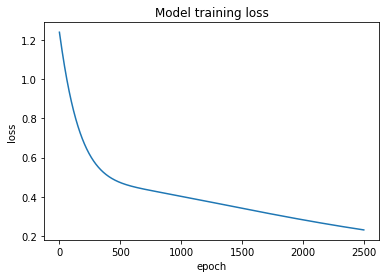

In [4]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data#, data.target
scale(X)

trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression= list()
all_grads= list()
losses= list()
for epoch in range(2500):
    optimizer2.zero_grad()
    y_pred = model2(trainx)
    #print(y_pred)
    l = loss2(y_pred, trainy)
    losses.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model2.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters
    optimizer2.step()
all_wts_bias = np.array(wts_bias_progression).reshape(-1,4)
all_wts_bias_df= pd.DataFrame(all_wts_bias, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads = np.array(all_grads).reshape(-1,4)
all_grads_df= pd.DataFrame(all_grads, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses)

* **Following are the weights and bias for the ONLY layer in model, after 128 epochs of training**

In [5]:
li = list(model2.parameters())
li

[Parameter containing:
 tensor([[ 0.4330, -0.0650,  1.1211]], requires_grad=True),
 Parameter containing:
 tensor([2.8916e-08], requires_grad=True)]

In [6]:
print('Final weights gradients : {}\nFinal bias gradients: {}'.format(li[0].grad, li[1].grad))

Final weights gradients : tensor([[ 0.0510, -0.0111, -0.1237]])
Final bias gradients: tensor([1.4435e-08])


* **Following are gradients updated after each epochs**

In [7]:
all_grads_df

,beta_1,beta_2,beta_3,beta_4
0,-1.450522,-2.127095,-0.676503,-2.656797e-01
1,-1.447040,-2.118273,-0.675777,-2.636797e-01
2,-1.443560,-2.109453,-0.675052,-2.616801e-01
3,-1.440078,-2.100635,-0.674326,-2.596813e-01
4,-1.436598,-2.091819,-0.673600,-2.576833e-01
...,...,...,...,...
2495,0.051157,-0.011115,-0.123845,8.847564e-09
2496,0.051129,-0.011109,-0.123801,2.421439e-08
2497,0.051101,-0.011102,-0.123757,6.752089e-08
2498,0.051072,-0.011096,-0.123713,3.445894e-08


* **Following computes the values at gradients w.r.t all inputs `X`**

In [8]:
optimizer2.zero_grad()
y_pred = model2(trainx)
l = loss2(y_pred, trainy)
l.backward()
i_grads= trainx.grad
#all_grads.append(i_grads)
#grad w.r.t input dataset Could be computed for every epoch

i_grads.shape

torch.Size([150, 3])

In [9]:
all_grads_df.describe()

,beta_1,beta_2,beta_3,beta_4
count,2500.000000,2500.000000,2500.000000,2.500000e+03
mean,-0.095115,-0.170166,-0.234389,-9.525506e-03
std,0.356338,0.389525,0.138281,3.705129e-02
min,-1.450522,-2.127095,-0.676503,-2.656797e-01
25%,-0.030689,-0.064817,-0.247942,-4.190952e-08
50%,0.064396,-0.021166,-0.174130,-8.381903e-09
75%,0.082895,-0.015591,-0.150212,8.381903e-09
max,0.094235,-0.011089,-0.123670,6.984919e-08


* **Mean values for weight(Beta_1-3) and bias(beta_4) gradients**

In [10]:
all_grads_df.describe().iloc[1]

beta_1   -0.095115
beta_2   -0.170166
beta_3   -0.234389
beta_4   -0.009526
Name: mean, dtype: float64

* **Evaluating same data with linear regression from statsmodel**

In [11]:
import statsmodels.api as sm
feats, targets= X[:,:-1], X[:,-1]
feats= sm.add_constant(feats, prepend=False)

In [12]:
model = sm.OLS(targets, feats, hasconst=True)
result= model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     734.4
Date:                Thu, 12 Mar 2020   Prob (F-statistic):           7.83e-88
Time:                        19:28:05   Log-Likelihood:                -45.701
No. Observations:                 150   AIC:                             99.40
Df Residuals:                     146   BIC:                             111.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2446      0.056     -4.363      0.0

* **Weights and biases from modelstats regression model**

In [13]:
result.params

array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17])

* **pytorch_params vs. statsmodel_params**

In [14]:
di = dict(zip('pytorch_grads,pytorch_params,statsmodel_params'.split(','), [all_grads[-1,:], all_wts_bias[-1,:], result.params]))#all_grads
di

{'pytorch_grads': array([ 5.10438569e-02, -1.10894283e-02, -1.23669505e-01,  1.44354999e-08]),
 'pytorch_params': array([ 4.33246076e-01, -6.50657341e-02,  1.12046862e+00,  2.93877651e-08]),
 'statsmodel_params': array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17])}

In [15]:
comp_df = pd.DataFrame(di)
comp_df

,pytorch_grads,pytorch_params,statsmodel_params
0,5.104386e-02,4.332461e-01,-2.446118e-01
1,-1.108943e-02,-6.506573e-02,7.286124e-02
2,-1.236695e-01,1.120469e+00,2.810966e+00
3,1.443550e-08,2.938777e-08,9.367507e-17


* **Plots**

In [16]:
def scatter_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.5
    max_x = max(list(x)+list(y)) + 0.5
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    ax.scatter(x, y, c="red")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
def hexbin_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.1
    max_x = max(list(x)+list(y)) + 0.1
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    hbin= ax.hexbin(x, y, gridsize=25, mincnt=2)
    cb = fig.colorbar(hbin, ax=ax)
    cb.set_label('occurence_density')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [17]:
##Re-Scaling
#from sklearn.linear_model import LinearRegression
#clf= LinearRegression()
#clf.fit(comp_df['pytorch_params'].values.reshape(-1,1), comp_df['statsmodel_params'].values.reshape(-1,1))
#n1= clf.predict(comp_df['pytorch_params'].values.reshape(-1,1))
#n2= clf.predict(comp_df['statsmodel_params'].values.reshape(-1,1))

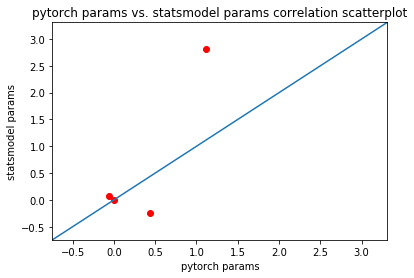

In [18]:
scatter_plot(comp_df['pytorch_params'].values,comp_df['statsmodel_params'].values, 'pytorch params' ,'statsmodel params')#n1,n2, 'abc','bcd')

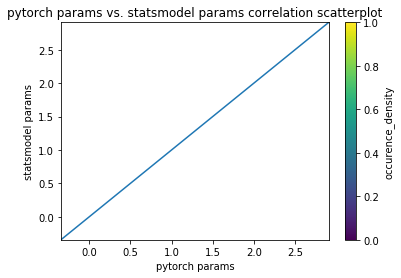

In [19]:
hexbin_plot(comp_df['pytorch_params'].values,comp_df['statsmodel_params'].values, 'pytorch params' ,'statsmodel params')

______________________

In [ ]:
#def model():
#    class network(nn.Module):
#        def __init__(self):
#            super(network, self).__init__()
#            self.fc1 = nn.Linear(4, 100)
#            self.fc2 = nn.Linear(100, 100)
#            self.fc3 = nn.Linear(100, 3)
#            self.softmax = nn.Softmax(dim=1)
#
#        def forward(self, X):
#            X = F.relu(self.fc1(X))
#           X = self.fc2(X)
#            X = self.fc3(X)
#            X = self.softmax(X)
#            return X
#    model= network()
#    optimizer = optim.Adam(model.parameters())
#    criterion= nn.CrossEntropyLoss()
#    return model, optimizer, criterion